In [0]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 58kB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import tensorflow as tf
from tensorflow import keras
import tools._my_tools as mt
import numpy as np

In [0]:
X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=True)

In [0]:
# X_train = X_train.swapaxes(1,3)
# X_train = X_train.swapaxes(1,2)
# X_test = X_test.swapaxes(1,3)
# X_test = X_test.swapaxes(1,2)

# y_train = np.expand_dims(y_train,3)
# y_test = np.expand_dims(y_test,3)

In [2]:
def test_lambda(x):
  tmp = tf.math.scalar_mul(30,x)
  a = tf.math.floor(tmp)
  b = tf.math.ceil(tmp)
  res = tf.math.divide(tf.math.floordiv(tf.math.add(a,b),3),15)
  return tmp

def convBlock(x, depth):
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  l = keras.layers.MaxPooling2D((2,2),padding='same')(l)
  
  return l

def deconvBlock(x, depth):
#   l = keras.layers.Conv2DTranspose(depth,(4,4),strides=2,padding='same',activation='relu')(x)
  l = keras.layers.UpSampling2D((2, 2), interpolation='bilinear')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  
  return l
  


input_img = keras.layers.Input((96,96,2))

c1 = convBlock(input_img, 32)
c2 = convBlock(c1, 64)
c3 = convBlock(c2, 128)
c4 = convBlock(c3, 256)
# encoded = convBlock(c4, 512)

# d4 = deconvBlock(c4,256)
# d4 = keras.layers.Add()([c4,d4])
# d4 = keras.layers.ReLU()(d4)
# --
d3 = deconvBlock(c4, 128)
# d3 = keras.layers.Add()([c3,d3])

d3 = keras.layers.ReLU()(d3)
# --
d2 = deconvBlock(d3, 64)
d2 = keras.layers.Add()([c2,d2])
d2 = keras.layers.ReLU()(d2)
# --
d1 = deconvBlock(d2, 32)
d1 = keras.layers.Add()([c1,d1])
d1 = keras.layers.ReLU()(d1)
# --
# decoded = deconvBlock(d1, 1)
# l = keras.layers.Conv2DTranspose(1,(4,4),strides=2,padding='same',activation='relu')(d1)
l = keras.layers.UpSampling2D((2, 2), interpolation='bilinear')(d1)
decoded = keras.layers.Conv2D(1,(3,3),activation='relu',padding='same')(l)
# decoded = keras.layers.Lambda(test_lambda)(decoded)
  
# out = keras.layers.Activation('sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=False)

Using TensorFlow backend.


In [4]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 2)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
checkpoint_path = "09/cp"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

batch_size = 16
num_epoch = 4
#model training
model_log = autoencoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,          
          validation_data=(X_test, y_test),
          callbacks = [cp_callback])

Train on 149872 samples, validate on 49958 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/4


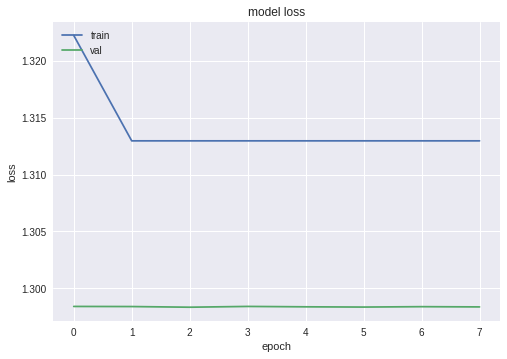

In [11]:
import matplotlib.pyplot as plt

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


# model_log.history.keys()

In [3]:
autoencoder.load_weights("09/02_sigmoid/09/cp")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd8a97240> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f6cd8b69b38>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd8a4aa90> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd8a97240>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd8a216a0> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd8a4aa90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6cd89b3c50> and <tensorflow.python.keras.layers.merge.Add object at 0x7f6cd8a4a470>).


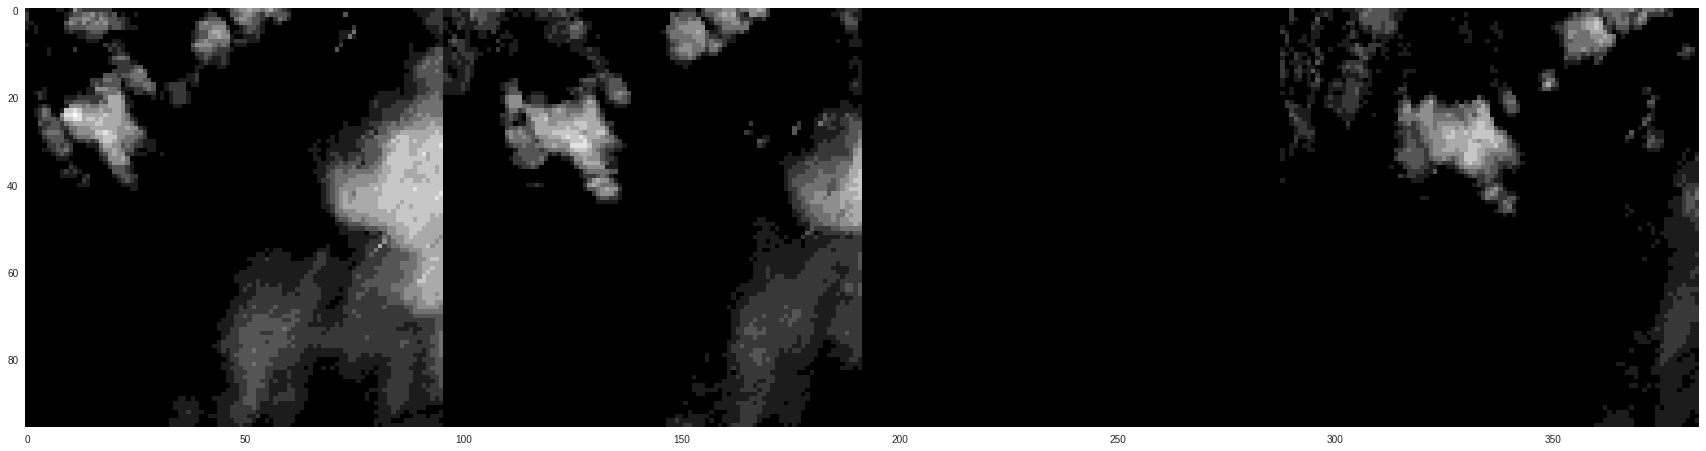

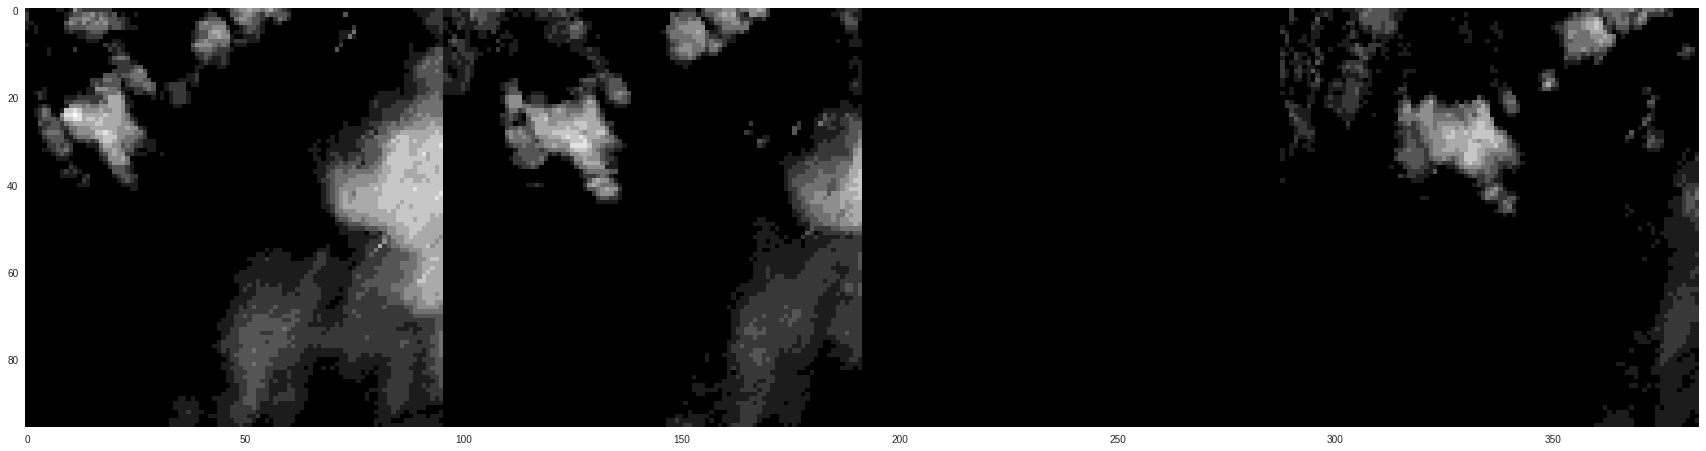

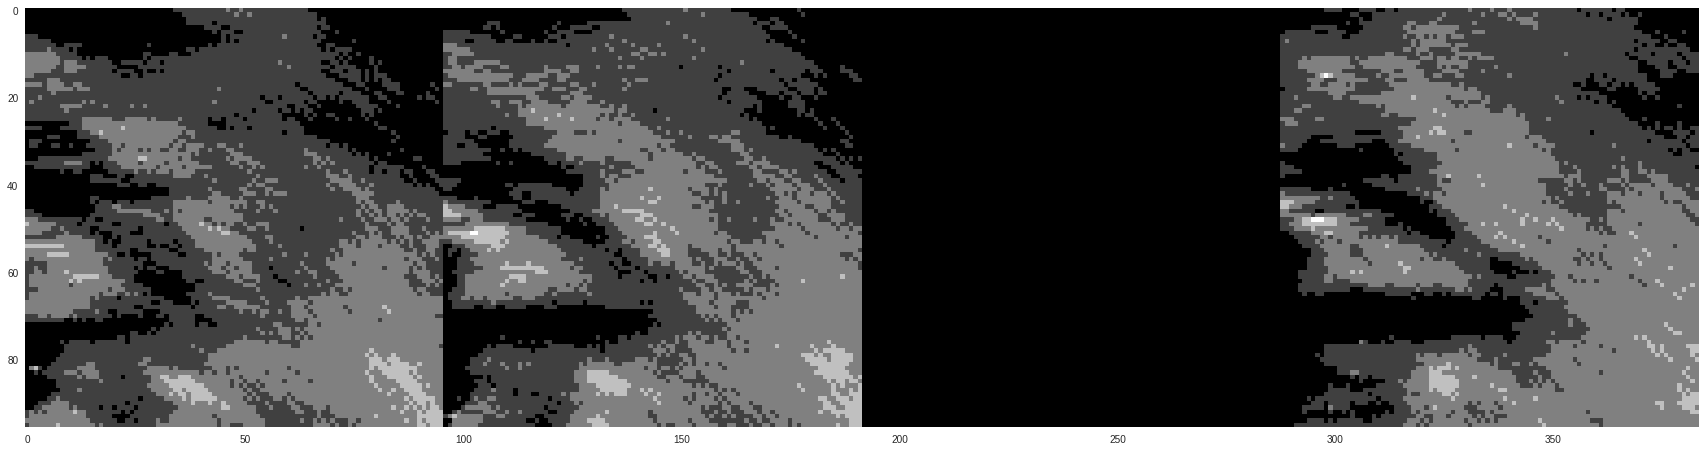

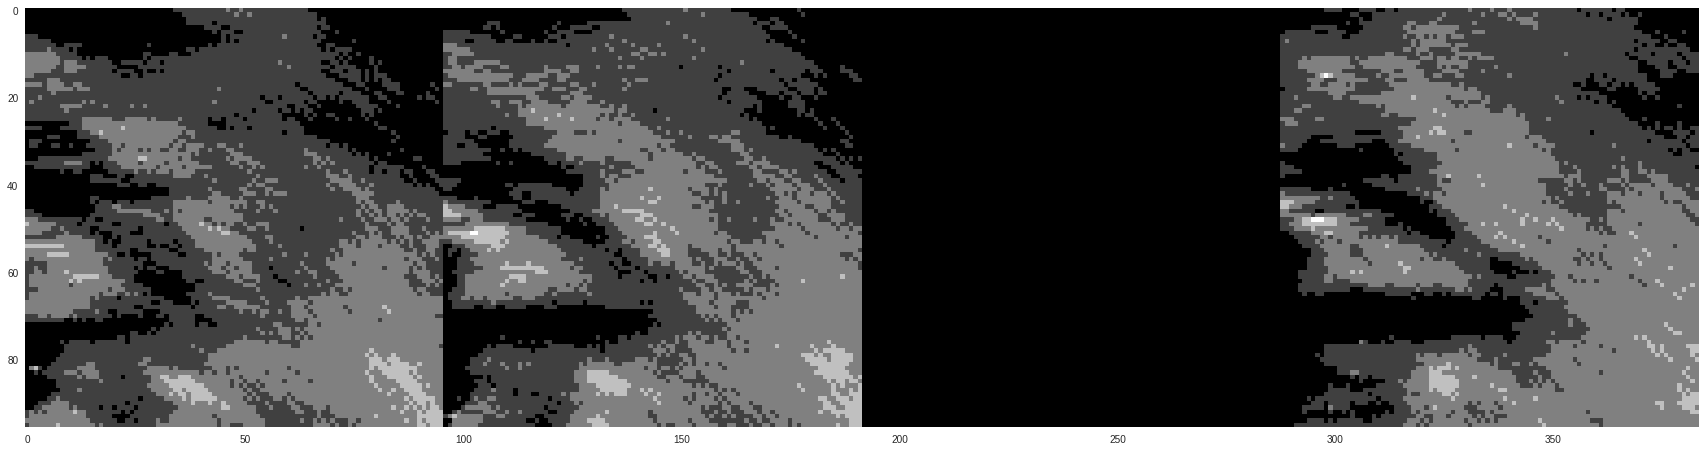

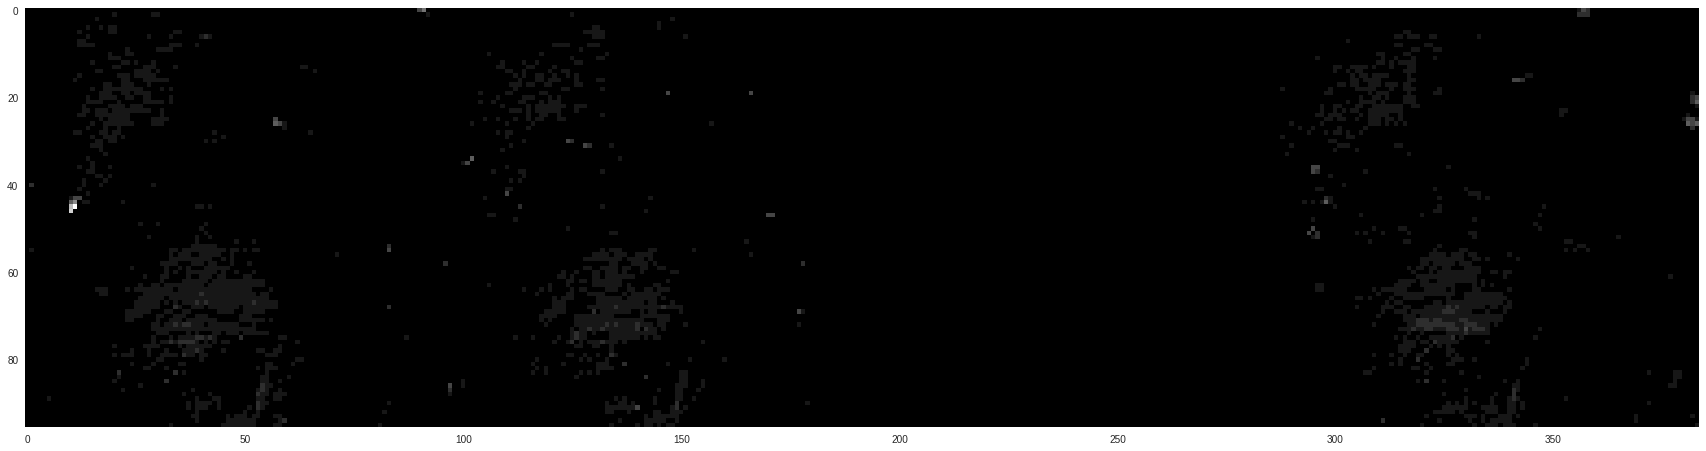

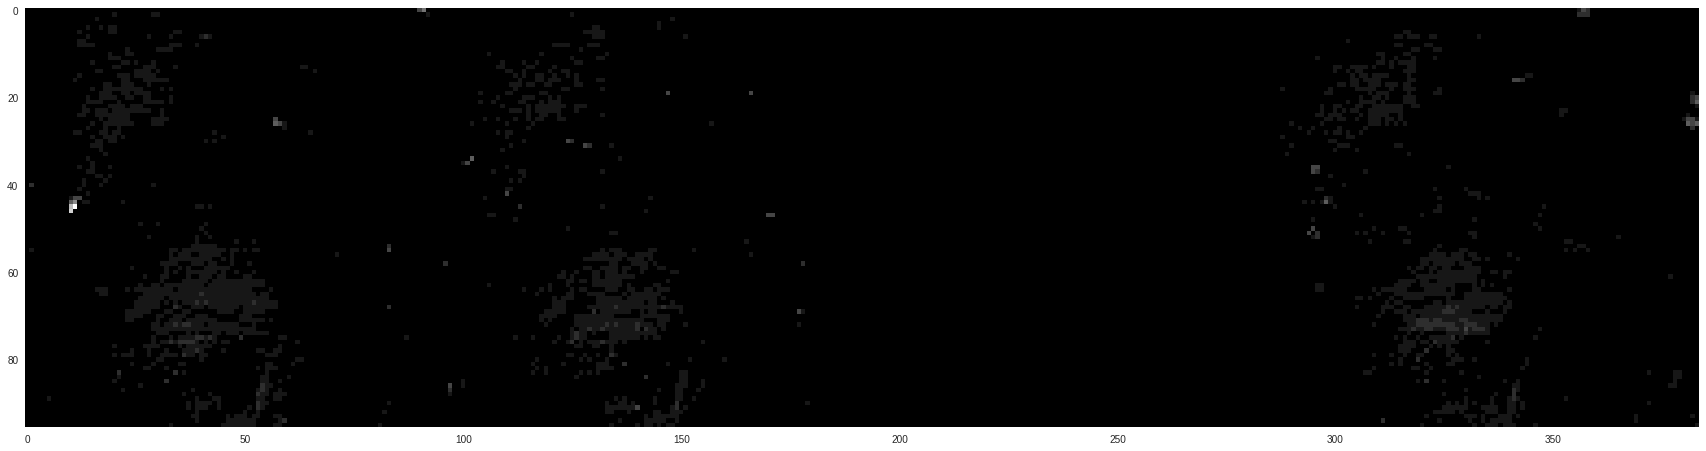

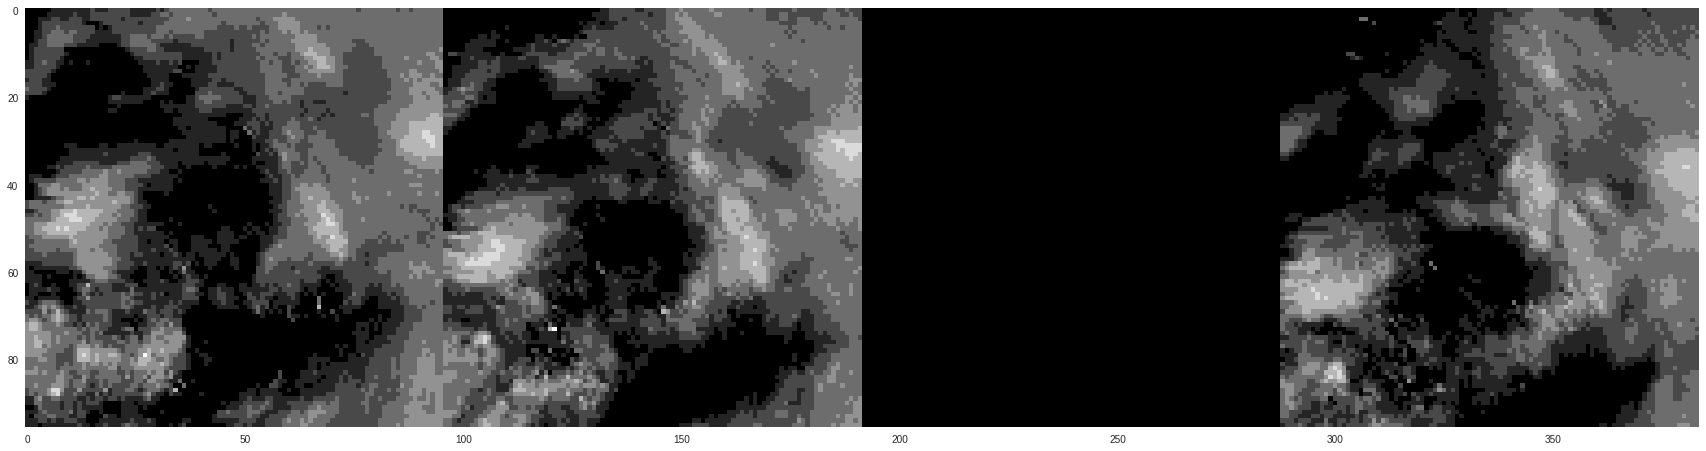

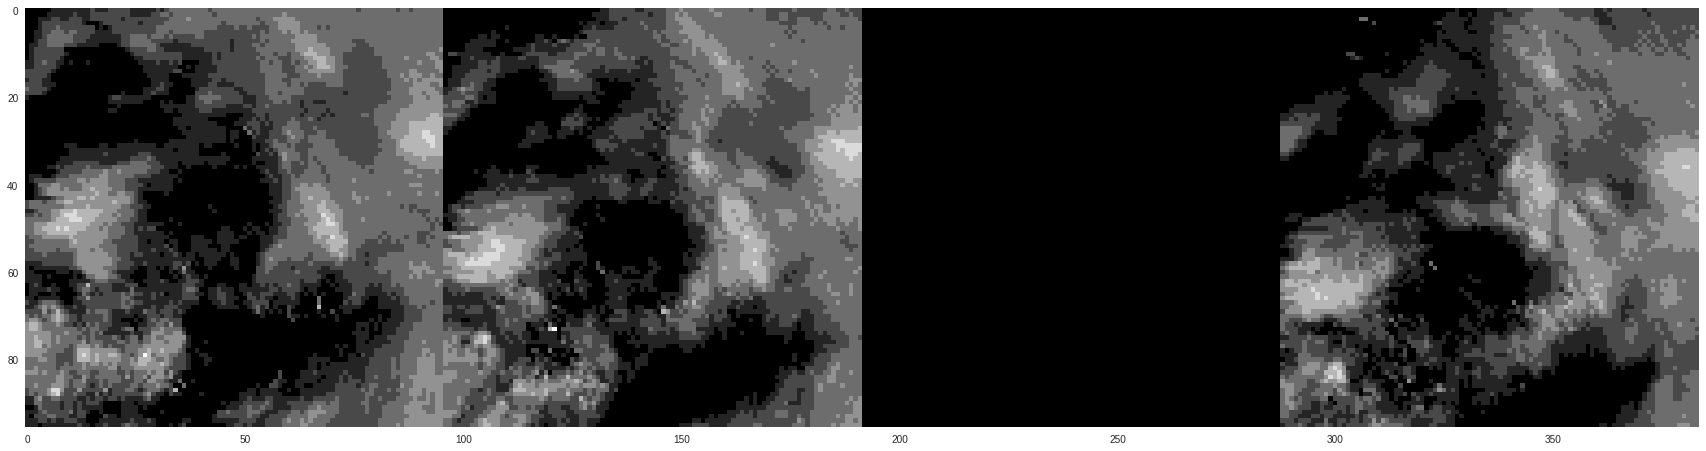

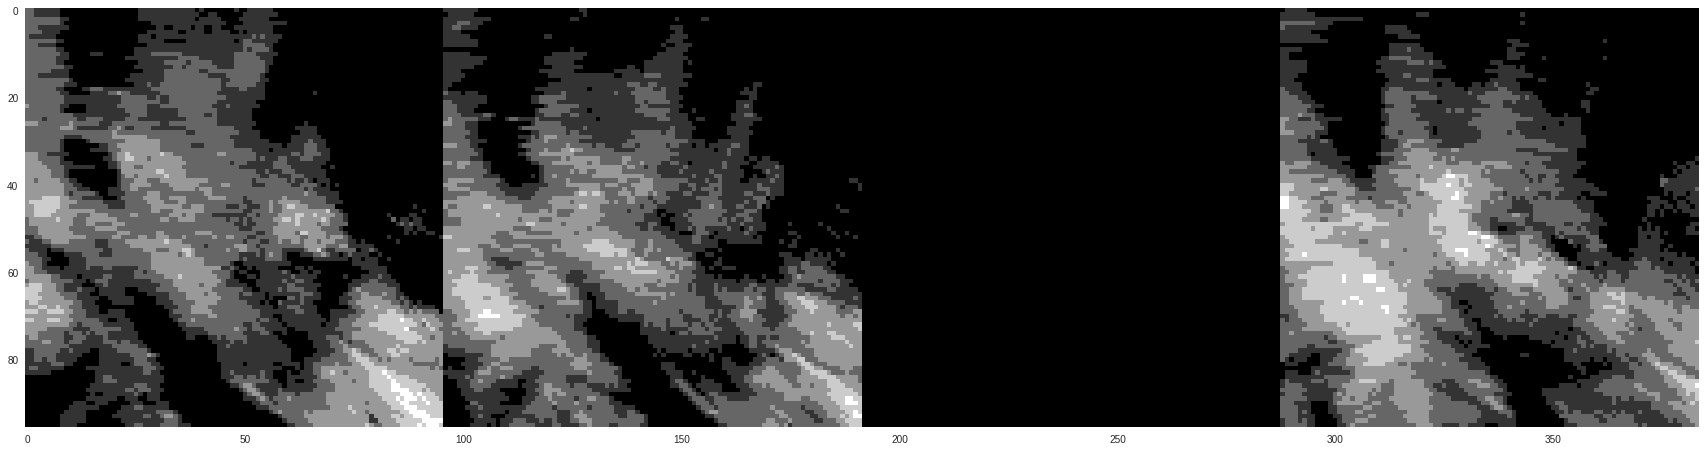

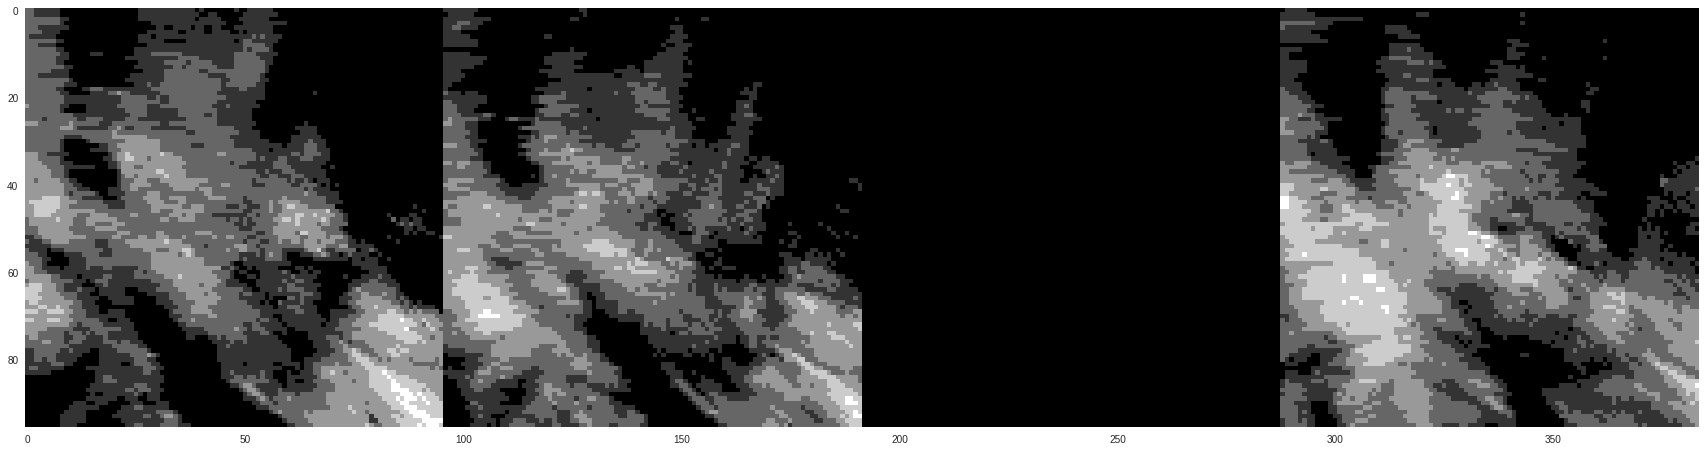

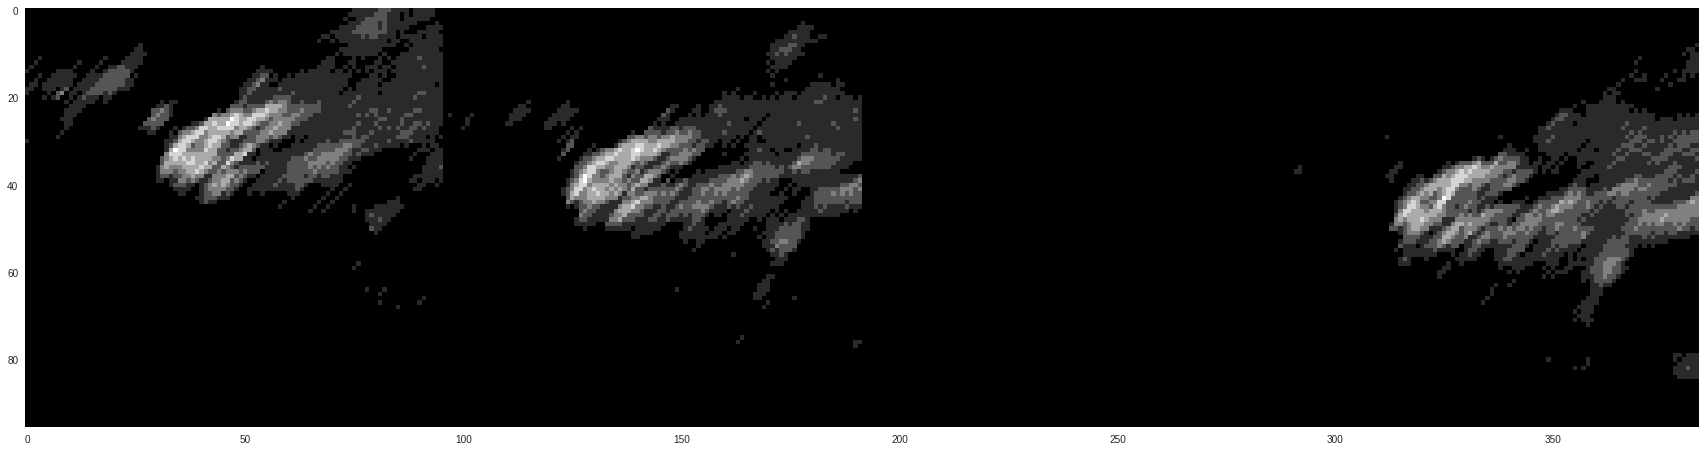

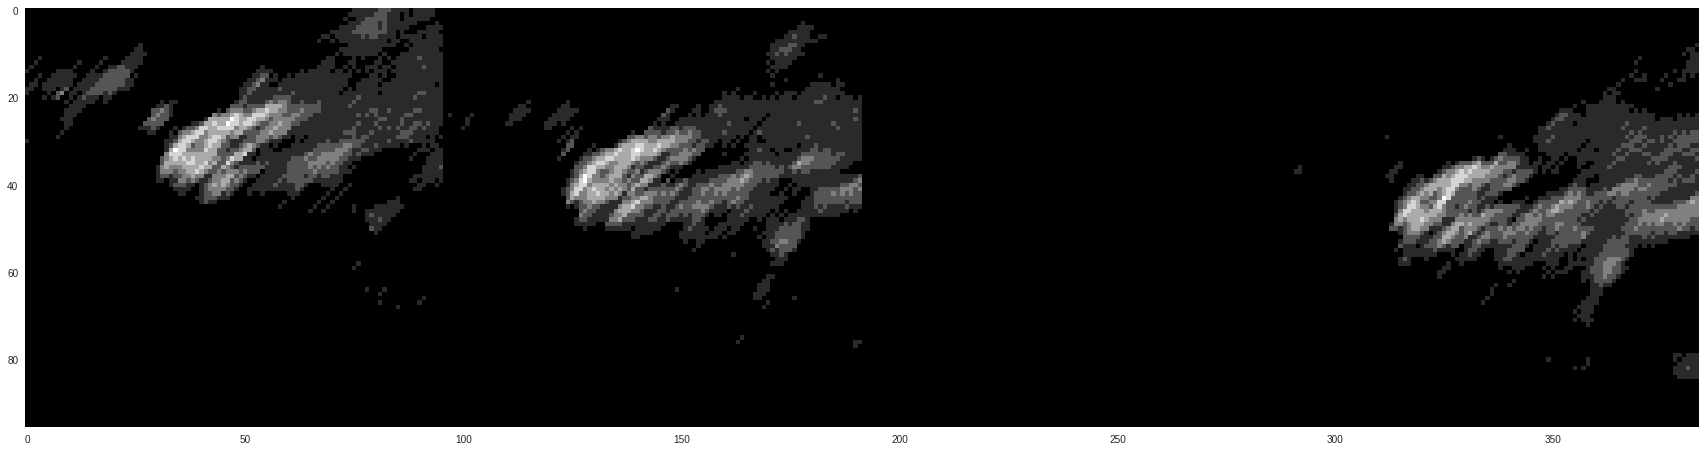

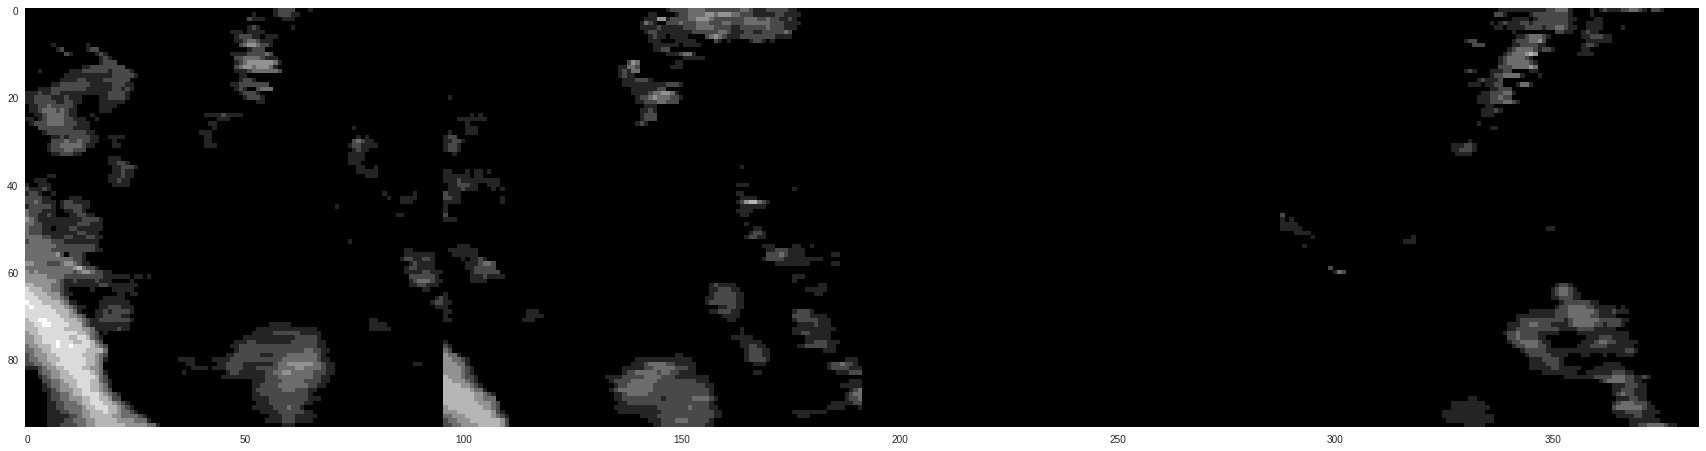

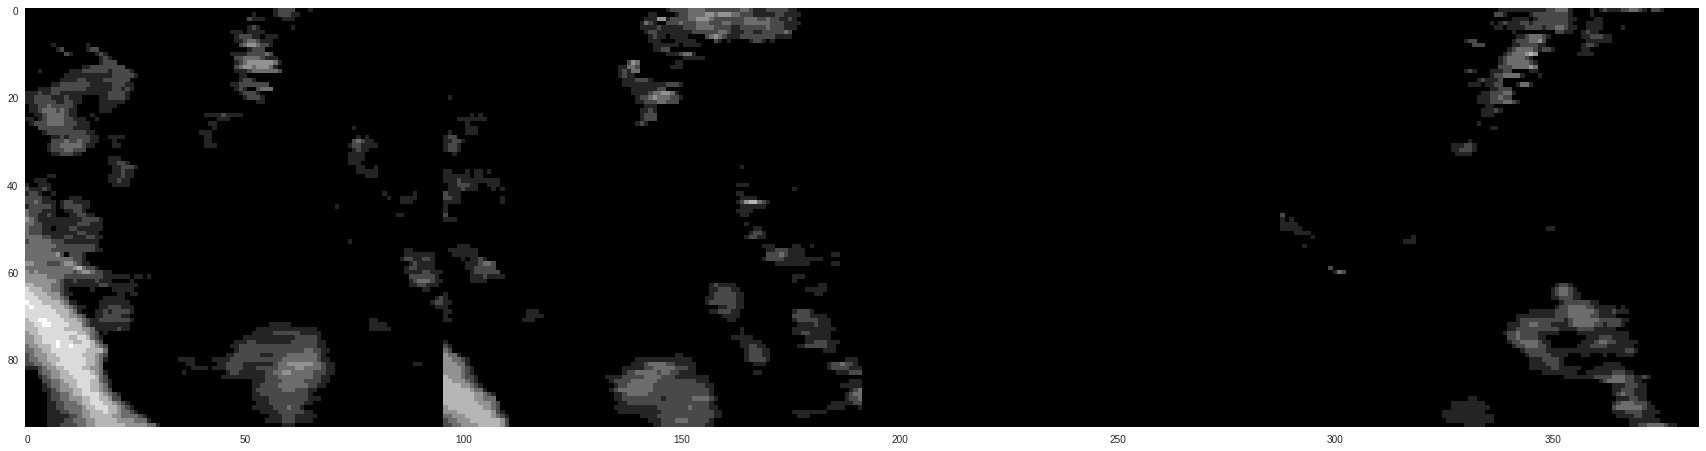

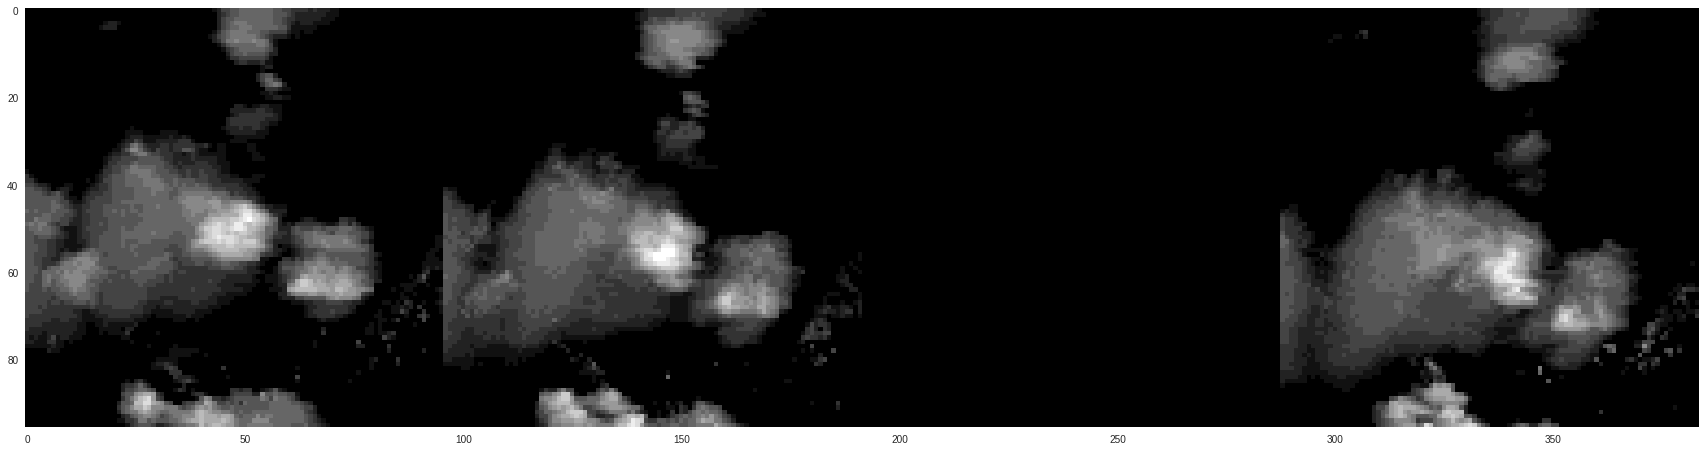

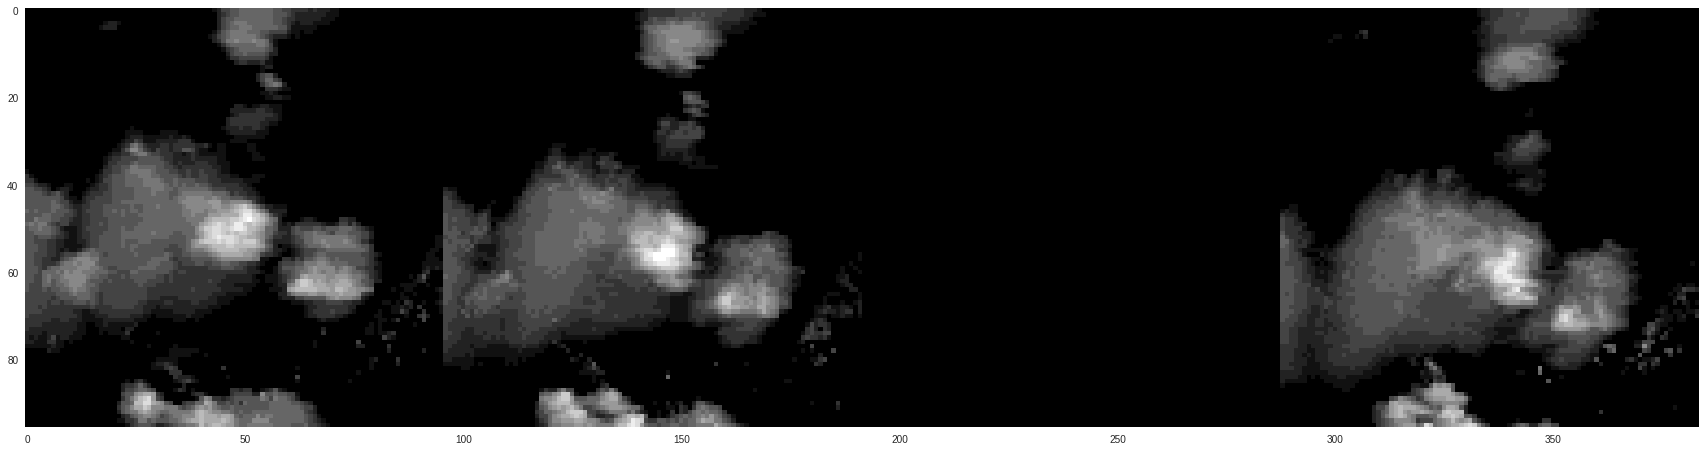

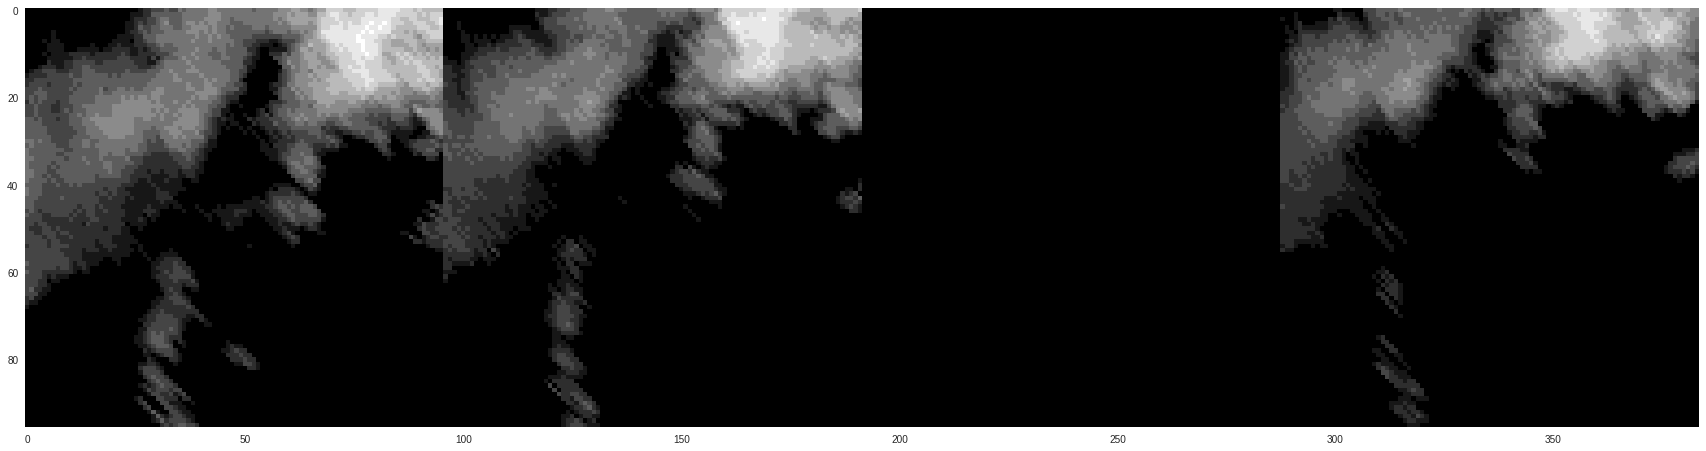

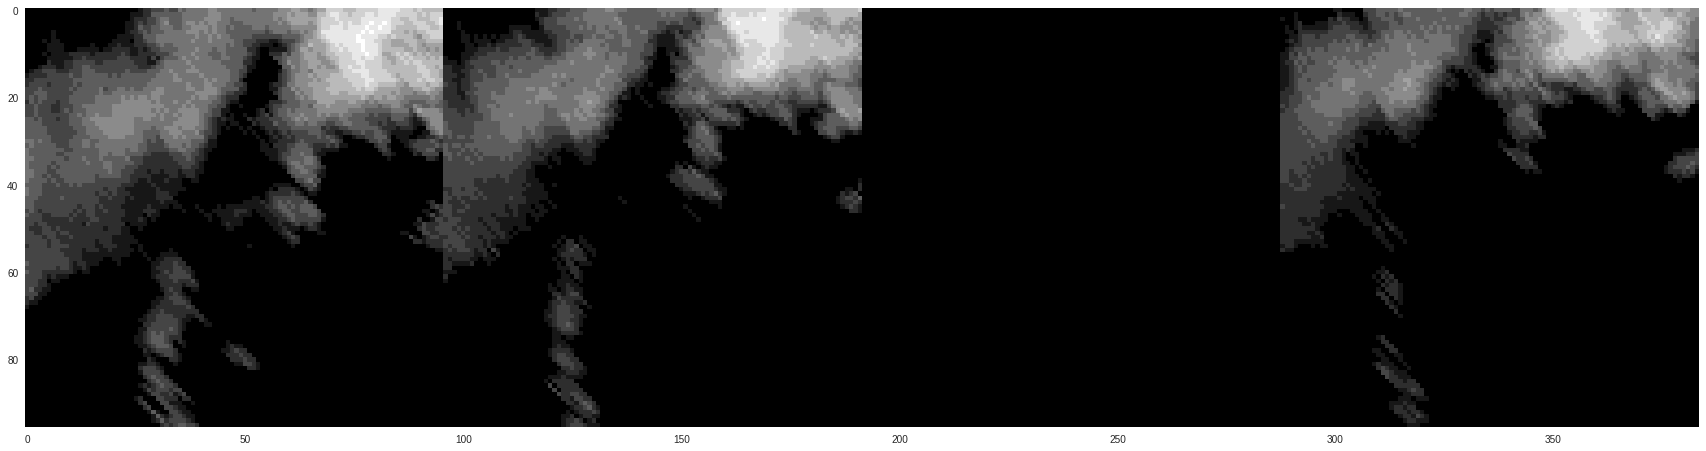

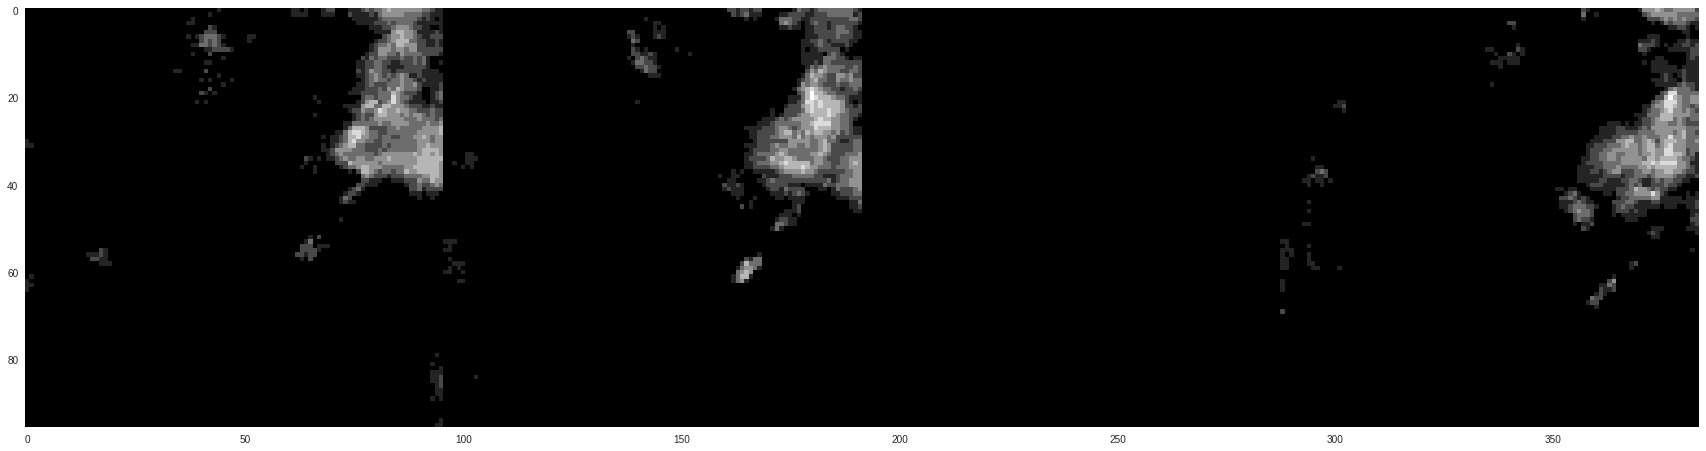

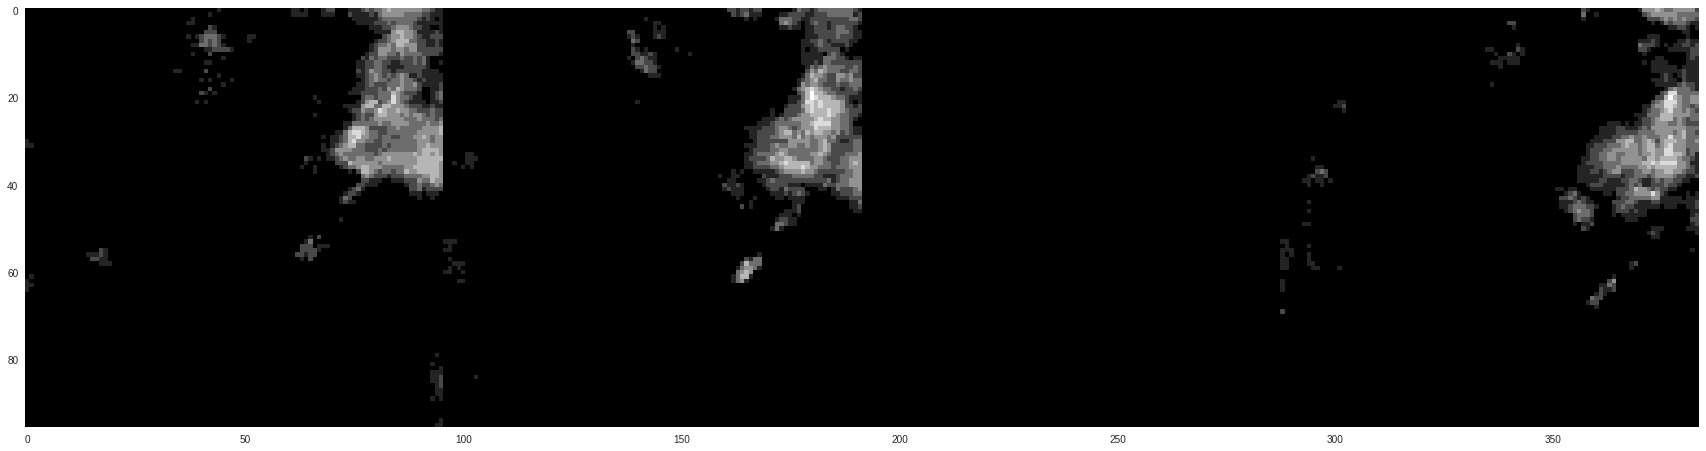

In [27]:
def test_py(x):
  tmp = x * 30
  a = np.floor(tmp)
  b = np.ceil(tmp)
  res = ((a+b)//3)/15
  return res


N = 10

res = autoencoder.predict(X_test[:10])
res2 = test_py(res)

for i in range(10):
  compare(i,X_test,y_test,res)
  compare(i,X_test,y_test,res2)
  

In [0]:
!zip fig.zip *.png

updating: 00.png (deflated 1%)
updating: 01.png (deflated 4%)
updating: 02.png (deflated 1%)
updating: 03.png (deflated 2%)
updating: 04.png (deflated 3%)
updating: 05.png (deflated 1%)
updating: 06.png (deflated 1%)
updating: 07.png (deflated 0%)
updating: 08.png (deflated 2%)
updating: 09.png (deflated 0%)


In [0]:
!zip -r weights.zip 09/

  adding: 09/ (stored 0%)
  adding: 09/checkpoint (deflated 34%)
  adding: 09/cp.data-00000-of-00001 (deflated 8%)
  adding: 09/cp.index (deflated 69%)


In [0]:
!unzip weights.zip

Archive:  weights.zip
   creating: 09/
  inflating: 09/checkpoint           
  inflating: 09/cp.data-00000-of-00001  
  inflating: 09/cp.index             


In [5]:
import tools._video_tools as vt
import tools._my_tools as mt

def fn(img1, img2):
    img1 = img1.reshape([1,96,96,1])
    img2 = img2.reshape([1,96,96,1])
    x = np.concatenate((img1, img2),axis=3)
    res = autoencoder.predict(x)
    
    return res

in_f = "24h_cropped/"
out_f = "tmp/out/"


vt.interpolateFolderRec(fn, in_f, out_f, 16)

radarcs1801050000_0000000000000000
radarcs1801050000_1000000000000000


UnimplementedError: Fused conv implementation does not support grouped convolutions for now.
	 [[{{node conv2d_8/Relu}}]]